# Import The Useable Libraries:

In [584]:
import numpy as np
import pandas as pd
import string
import random
from time import time
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad
from Crypto.Random import get_random_bytes
import base64
from Crypto.Util.Padding import unpad
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from decimal import Decimal, getcontext
import scienceplots
from aes import encrypt, decrypt

# **Define The Global Notebook Settings:** 

In [585]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 500)
plt.rcParams.update({'font.size': 14})
plt.style.use(['science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'

# **Define The Global Variables:** 

In [586]:
def get_random_8chars(chars_length, n_sambles):
    random_chars = []
    for i in range(0, n_sambles, 1):
        letters = string.ascii_letters
        random_chars.append("".join(random.choice(letters)
                            for _ in range(chars_length)))
    return "".join(random_chars)

In [587]:
polynomials = [
    ([2, 2.5, 3], [2, -2, -3]),
    ([3, 3.5, 4, 4.5], [3, 3.7, -4, -4.5]),
    ([4, 4.5, 5, 5.5, 6], [-4, 4, 5, -5.5, -6]),
    ([5, 5.5, 6, 6.5, 7, 7.5], [5, 5.3, 6, -6.5, -7, -7.5]),
    ([6, 6.5, 7, 7.5, 8, 8.5, 9], [6, 6.7, 7, 7.5, -8, -8.5, -9]),
]

In [588]:
Degrees = []
for poly in polynomials:
    Degrees.append(len(poly[0]) - 1)

In [589]:
block_size = 10

min_block = ' '*block_size
max_block = '~'*block_size

min_rep = int.from_bytes(
    min_block.encode('utf-8'), byteorder='big')
max_rep = int.from_bytes(
    max_block.encode('utf-8'), byteorder='big')

print(min_rep, max_rep)

151708338147718170943520 597351581456640298090110


In [590]:
text_samples = []
text_sizes = [5000, 7500, 10000, 12500, 15000,
              17500, 20000, 22500, 25000, 27500, 30000]
for size in text_sizes:
    text_samples.append(get_random_8chars(block_size, size))

In [591]:
secant_different_sizes_enc = []
secant_different_sizes_dec = []
secant_different_sizes_total = []

secant_different_deg_enc = []
secant_different_deg_dec = []
secant_different_deg_total = []

# ================

aes_different_sizes_enc = []
aes_different_sizes_dec = []
aes_different_sizes_total = []


aes_different_keys_enc = []
aes_different_keys_dec = []
aes_different_keys_total = []

# **Define The Global Classes:** 

In [592]:
class ibga(object):
    def __init__(self, text, x, y):
        if type(text) != str or len(x) != len(y):
            raise ValueError("Invalid parameters passed")
        self.text = text
        self.len_text = len(text)
        self.x = [Decimal(i) for i in x]
        self.y = [Decimal(i) for i in y]
        self.coefs = None
        self.maximium_8utf_chars = Decimal(max_rep)
        self.minimum_8utf_chars = Decimal(min_rep)
        self.len_x = len(x)

    def set_text(self, text):
        if type(text) != str:
            raise ValueError("Invalid text type passed")
        self.text = text

    def set_x_y(self, x, y):
        if len(x) != len(y):
            raise ValueError("Invalid x, y points size passed")
        self.x = [Decimal(i) for i in x]
        self.y = [Decimal(i) for i in y]
        self.len_x = len(x)
        self.coefs = None

    def encode_and_get_int_values(self, chunk):
        byte_representation = chunk.encode('utf-8')
        integer_representation = int.from_bytes(
            byte_representation, byteorder='big')
        return integer_representation

    def get_normalized_value(self, integer_value):
        decimal_value = Decimal(integer_value)
        normalized_value = (decimal_value - self.minimum_8utf_chars) / \
            (self.maximium_8utf_chars - self.minimum_8utf_chars)
        return normalized_value

    def get_inverse_normalized_value(self, normalized_value):
        integer_value = (normalized_value *
                         (self.maximium_8utf_chars - self.minimum_8utf_chars)) + self.minimum_8utf_chars
        return integer_value

    def get_normalized_values(self):
        normalized_values = []
        chunks = self.len_text // block_size
        beg, end = 0, 0
        if chunks:
            end = block_size
            for i in range(0, chunks, 1):
                chunk = self.text[beg: end]
                normalized_values.append(
                    self.get_normalized_value(self.encode_and_get_int_values(chunk)))
                beg = end
                end = beg + block_size
        if (self.len_text / block_size) % 1 != 0:
            chunk = self.text[end:]
            normalized_values.append(
                self.get_normalized_value(self.encode_and_get_int_values(chunk)))
        return normalized_values

    def get_interger_values(self, normalized_values):
        interger_values = []
        for normalized_value in normalized_values:
            interger_values.append(
                self.get_inverse_normalized_value(normalized_value))
        return interger_values

    def decode_and_get_strings(self, int_values):
        strings = []
        for int_value in int_values:
            int_value = np.ceil(int_value)
            byte_representation = int_value.to_bytes(
                (int_value.bit_length() + 7) // 8, byteorder='big')
            text = byte_representation.decode('utf-8')
            strings.append(text)
        return "".join(strings)

    def decode_and_get_string(self, int_value):
        int_value = np.ceil(int_value)
        byte_representation = int_value.to_bytes(
            (int_value.bit_length() + 7) // 8, byteorder='big')
        return (byte_representation.decode('utf-8'))

    def newton_forward_coefficients(self):
        n = len(self.x)
        coefficients = np.zeros(n, dtype=Decimal)
        for i in range(n):
            coefficients[i] = Decimal(self.y[i])
        for j in range(1, n):
            for i in range(n - 1, j - 1, -1):
                coefficients[i] = (coefficients[i] - coefficients[i - 1]) / \
                    (self.x[i] - self.x[i - j])
        self.coefs = coefficients

    def evaluate_interpolated_value(self, target, normalized_value=Decimal(0)):
        n = self.len_x
        result = Decimal(self.coefs[-1])
        for i in range(n - 2, -1, -1):
            result = Decimal(result) * \
                (Decimal(target) - Decimal(self.x[i])) + Decimal(self.coefs[i])
        return result - normalized_value

    def evaluate_derivative(self, x, normalized_value):
        n = len(self.coefs) - 1
        result = Decimal(n) * (self.coefs[-1] - normalized_value)
        for i in range(n - 1, 0, -1):
            result = result * \
                (Decimal(x) - Decimal(self.x[i])) + Decimal(i) * self.coefs[i]
        return result

    def secant(self, x0, x1, normalized_value, tol=Decimal(10 ** -17)):
        x_prev = Decimal(x0)
        x_curr = Decimal(x1)

        while abs(x_curr - x_prev) > tol:
            fx_prev = self.evaluate_interpolated_value(
                x_prev, normalized_value)
            fx_curr = self.evaluate_interpolated_value(
                x_curr, normalized_value)

            if fx_curr - fx_prev == 0:
                raise ValueError(
                    "Secant method cannot converge. Division by zero.")

            x_next = x_curr - fx_curr * (x_curr - x_prev) / (fx_curr - fx_prev)
            x_prev, x_curr = x_curr, x_next

        return x_curr

    def encryption(self, root_finding_algorithm='secant'):
        cipher_text = []
        self.newton_forward_coefficients()
        normalized_values = self.get_normalized_values()
        algorithms = {
            'secant': self.secant,
        }
        if root_finding_algorithm not in algorithms:
            raise ValueError(
                f"Invalid algorithm_name. Expected one of: {', '.join(algorithms.keys())}")

        selected_algorithm = algorithms[root_finding_algorithm]

        for normalized_value in normalized_values:
            cipher_text.append(selected_algorithm(
                self.x[0], self.x[-1], normalized_value))

        return cipher_text

    def decryption(self, cipher_text):
        text = []
        for root in cipher_text:
            norm = self.evaluate_interpolated_value(root)
            inverse = self.get_inverse_normalized_value(norm)
            text.append(self.decode_and_get_string(Decimal(round(inverse))))
        return "".join(text)

# Get The Encryption & Decrytion & Total Times For Bisection , Secant Hyprid With Differrent Polynomials Degree 2 : 6

> **Hint**: 
> 1)  According To The Useable Root Finding Algorithm Uncomment Its Callable Function Inside The Encryption Function. 
> 2) Root Finding Algorithms Analysis Woerking With Block Size 4bytes For (Bisection , False Position).

### Get Encryption , Decryption , Total Times When Using Secant:

In [593]:
poly = polynomials[3]
for text in text_samples:
    obj = ibga(text, poly[0], poly[1])
    ibga_en_beg = time()
    ciper_text = obj.encryption('secant')
    ibga_en_end = time()
    enc_time = ibga_en_end - ibga_en_beg
    secant_different_sizes_enc.append(enc_time)

    ibga_dec_beg = time()
    text_decryption = obj.decryption(ciper_text)
    ibga_dec_end = time()
    dec_time = ibga_dec_end - ibga_dec_beg
    secant_different_sizes_dec.append(dec_time)

    secant_different_sizes_total.append(enc_time + dec_time)
    print(text_decryption == text)

print('='*10)

text = text_samples[-1]
for poly in polynomials:
    obj = ibga(text, poly[0], poly[1])
    ibga_en_beg = time()
    ciper_text = obj.encryption('secant')
    ibga_en_end = time()
    en_time = ibga_en_end - ibga_en_beg
    secant_different_deg_enc.append(en_time)

    ibga_dec_beg = time()
    text_decryption = obj.decryption(ciper_text)
    ibga_dec_end = time()
    dec_time = ibga_dec_end - ibga_dec_beg
    secant_different_deg_dec.append(dec_time)

    secant_different_deg_total.append(en_time + dec_time)
    print(text_decryption == text)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


### Using AES:

In [594]:
key = 'aMkjcMd#%)45'

keys = []
for i in range(len(polynomials)):
    keys.append(key*(i+1))

In [595]:
key = keys[1].encode('utf-8')
for text in text_samples:
    aes_enc_beg = time()
    ciphertext = encrypt(key, text.encode('utf-8'))
    aes_enc_end = time()

    enc_time = aes_enc_end - aes_enc_beg
    aes_different_sizes_enc.append(enc_time)

    aes_dec_beg = time()
    decrypted_text = decrypt(key, ciphertext)
    aes_dec_end = time()

    dec_time = aes_dec_end - aes_dec_beg
    aes_different_sizes_dec.append(dec_time)
    aes_different_sizes_total.append(enc_time + dec_time)

    print(decrypted_text.decode('utf-8') == text)


print('='*10)

text = text_samples[-1]
for key in keys:
    key = key.encode('utf-8')
    aes_enc_beg = time()
    ciphertext = encrypt(key, text.encode('utf-8'))
    aes_enc_end = time()

    enc_time = aes_enc_end - aes_enc_beg
    aes_different_keys_enc.append(enc_time)

    aes_dec_beg = time()
    decrypted_text = decrypt(key, ciphertext)
    aes_dec_end = time()

    dec_time = aes_dec_end - aes_dec_beg
    aes_different_keys_dec.append(dec_time)
    aes_different_keys_total.append(enc_time + dec_time)

    print(decrypted_text.decode('utf-8') == text)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


---

In [596]:
# Polynomial Deg & Text Array Size
print(polynomials)
polynomials_degrees = []
for poly in polynomials:
    polynomials_degrees.append(len(poly[0]) - 1)

print(polynomials_degrees)
print(text_sizes)

[([2, 2.5, 3], [2, -2, -3]), ([3, 3.5, 4, 4.5], [3, 3.7, -4, -4.5]), ([4, 4.5, 5, 5.5, 6], [-4, 4, 5, -5.5, -6]), ([5, 5.5, 6, 6.5, 7, 7.5], [5, 5.3, 6, -6.5, -7, -7.5]), ([6, 6.5, 7, 7.5, 8, 8.5, 9], [6, 6.7, 7, 7.5, -8, -8.5, -9])]
[2, 3, 4, 5, 6]
[5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000]


In [597]:
# Time Results
print(secant_different_sizes_enc)
print(secant_different_sizes_dec)
print(secant_different_sizes_total)
print(secant_different_deg_enc)
print(secant_different_deg_dec)
print(secant_different_deg_total)

print('='*10)

print(aes_different_sizes_enc)
print(aes_different_sizes_dec)
print(aes_different_sizes_total)
print(aes_different_keys_enc)
print(aes_different_keys_dec)
print(aes_different_keys_total)

[0.798245906829834, 1.2095019817352295, 1.7205908298492432, 2.0383408069610596, 2.5313568115234375, 2.699970245361328, 3.309830665588379, 3.651764392852783, 4.232214689254761, 4.512106418609619, 4.666464567184448]
[0.10038566589355469, 0.17577338218688965, 0.20737552642822266, 0.3383169174194336, 0.31630825996398926, 0.3997471332550049, 0.4277808666229248, 0.45087337493896484, 0.5000705718994141, 0.5931339263916016, 0.5891289710998535]
[0.8986315727233887, 1.3852753639221191, 1.9279663562774658, 2.376657724380493, 2.8476650714874268, 3.099717378616333, 3.7376115322113037, 4.102637767791748, 4.732285261154175, 5.105240345001221, 5.255593538284302]
[2.559879779815674, 3.29197096824646, 5.574459075927734, 4.65146803855896, 6.121952533721924]
[0.4807310104370117, 0.5282409191131592, 0.5697860717773438, 0.6068904399871826, 0.655689001083374]
[3.0406107902526855, 3.820211887359619, 6.144245147705078, 5.258358478546143, 6.777641534805298]
[0.8077447414398193, 0.7972919940948486, 1.00648212432

## Plotting Results:

### Different Text Size

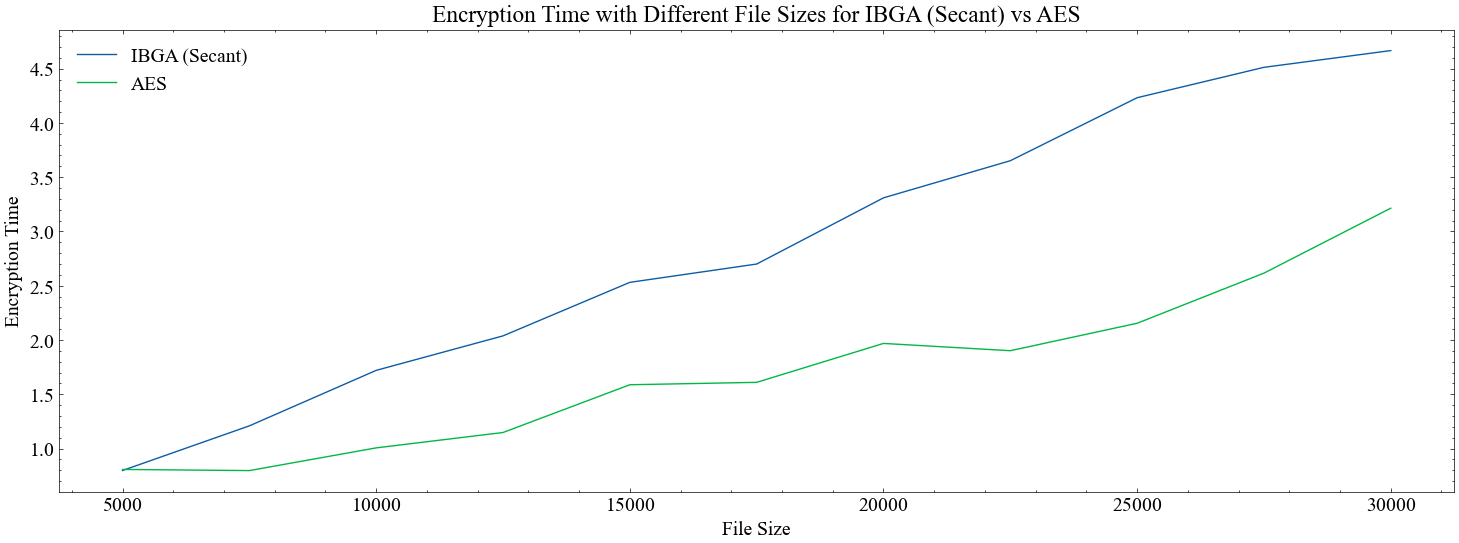

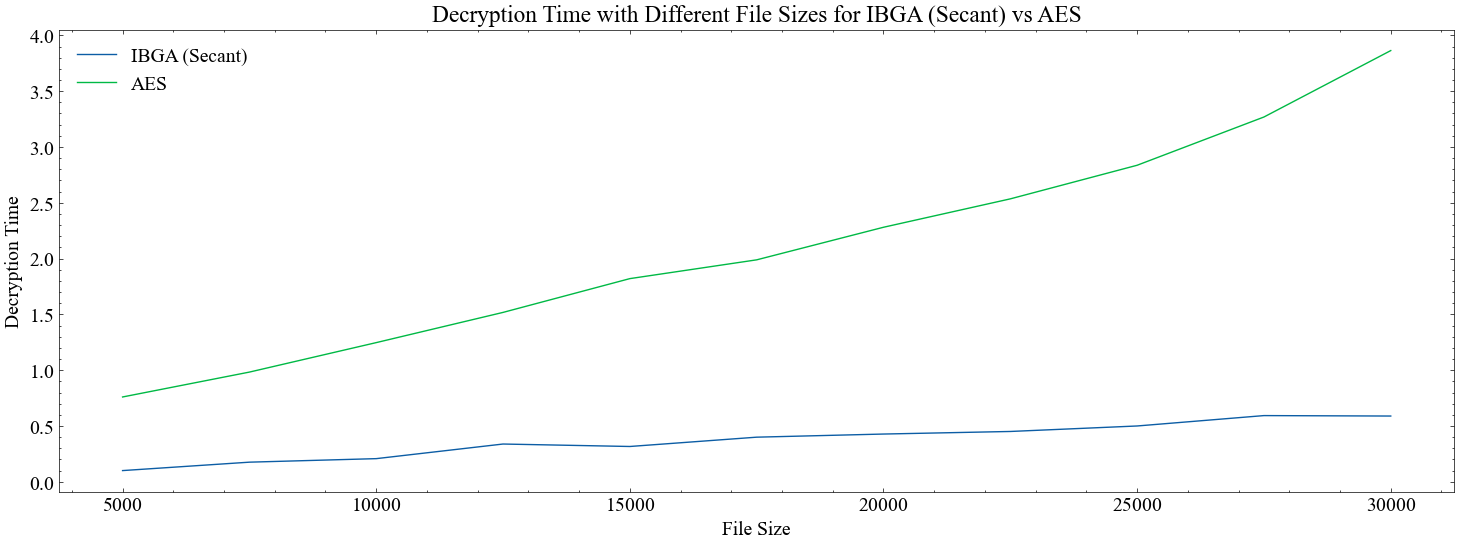

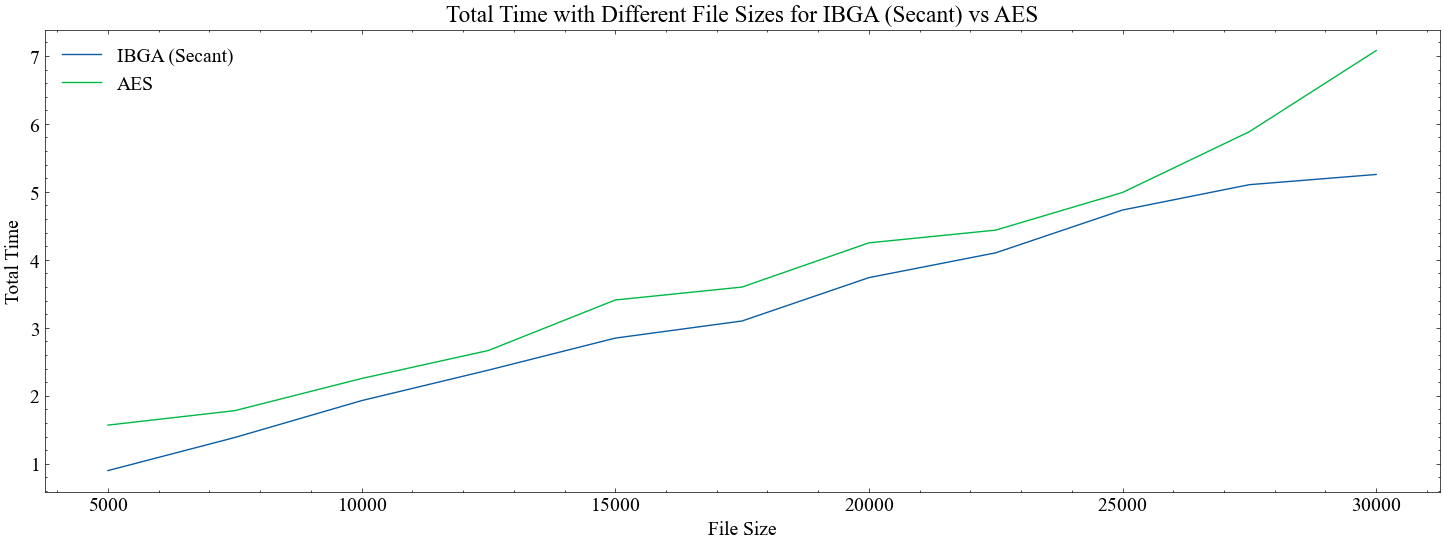

In [598]:
# Encryption Time Comparison
plt.figure(figsize=(18, 6))
plt.plot(text_sizes, secant_different_sizes_enc,  label='IBGA (Secant)')
plt.plot(text_sizes, aes_different_sizes_enc,  label='AES')
plt.xlabel('File Size')
plt.ylabel('Encryption Time')
plt.title('Encryption Time with Different File Sizes for IBGA (Secant) vs AES')
plt.legend()
plt.savefig(r"./encryption_time_comparison.svg", format="svg")
plt.show()

# Decryption Time Comparison
plt.figure(figsize=(18, 6))
plt.plot(text_sizes, secant_different_sizes_dec,  label='IBGA (Secant)')
plt.plot(text_sizes, aes_different_sizes_dec,  label='AES')
plt.xlabel('File Size')
plt.ylabel('Decryption Time')
plt.title('Decryption Time with Different File Sizes for IBGA (Secant) vs AES')
plt.legend()
plt.savefig(r"./decryption_time_comparison.svg", format="svg")
plt.show()

# Total Time Comparison
plt.figure(figsize=(18, 6))
plt.plot(text_sizes, secant_different_sizes_total,  label='IBGA (Secant)')
plt.plot(text_sizes, aes_different_sizes_total,  label='AES')
plt.xlabel('File Size')
plt.ylabel('Total Time')
plt.title('Total Time with Different File Sizes for IBGA (Secant) vs AES')
plt.legend()
plt.savefig(r"./total_time_comparison.svg", format="svg")
plt.show()

### Different Key Size & Polynomial Degree


In [599]:
# Flatten the list of degrees and keys
degrees = [len(poly[0]) - 1 for poly in polynomials]
key_sizes = [len(key) for key in keys]
# degrees.insert(0,0)
# key_sizes.insert(0,0)
print(degrees, key_sizes)

[2, 3, 4, 5, 6] [12, 24, 36, 48, 60]


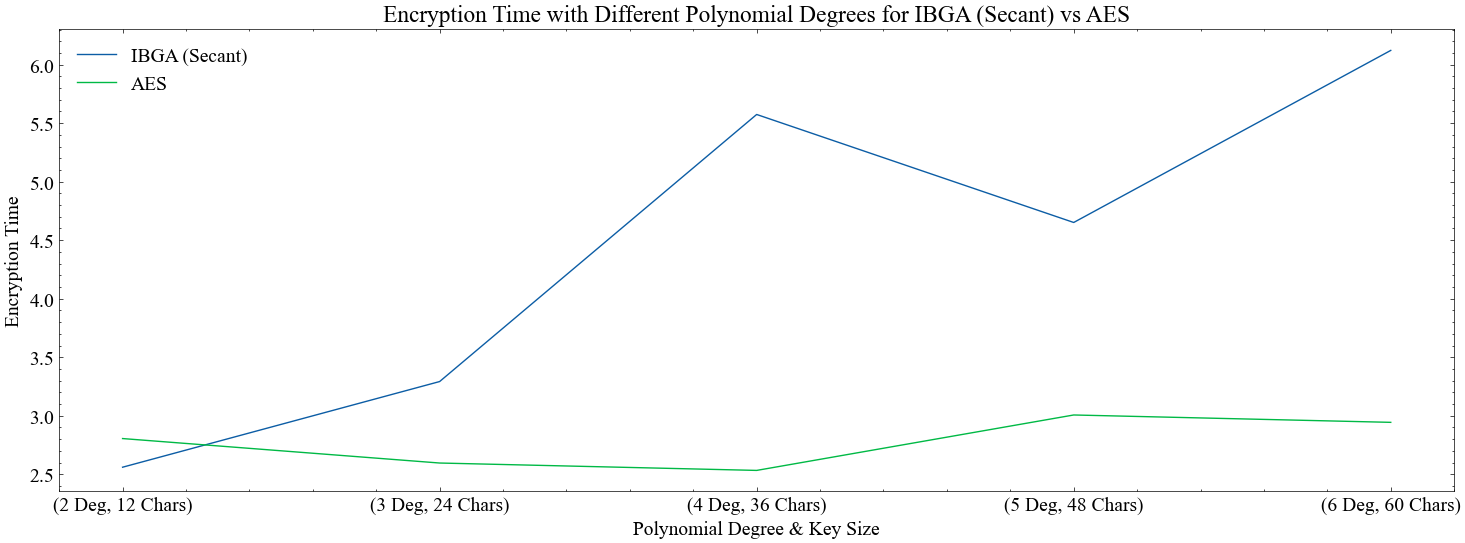

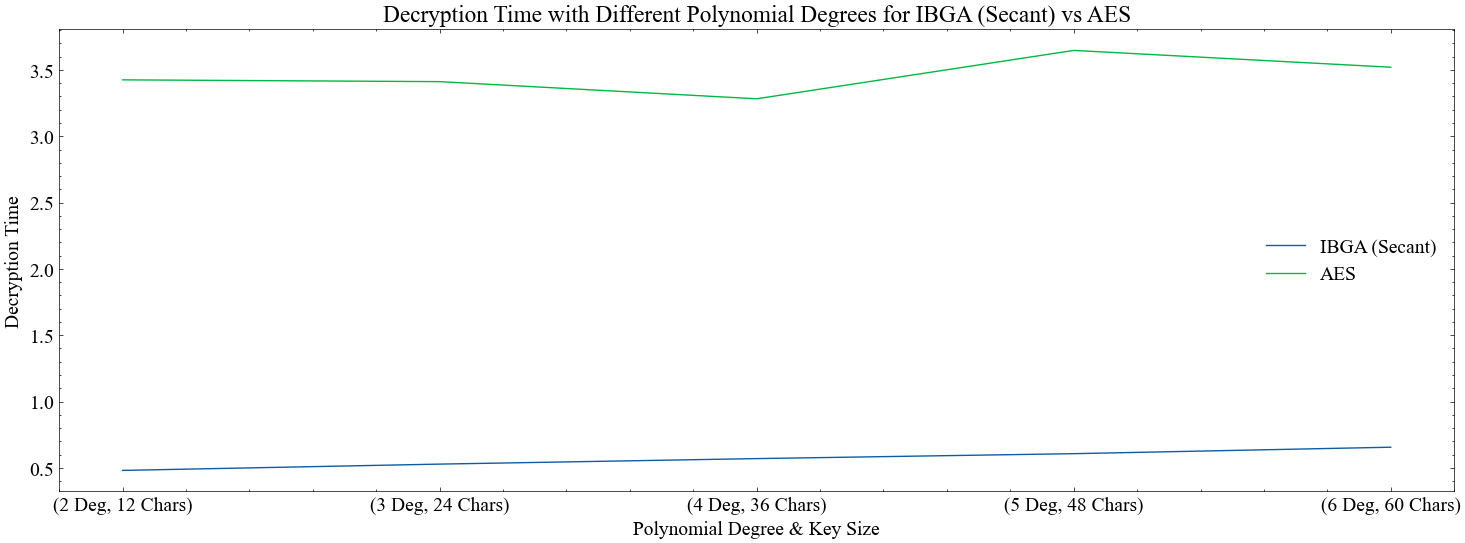

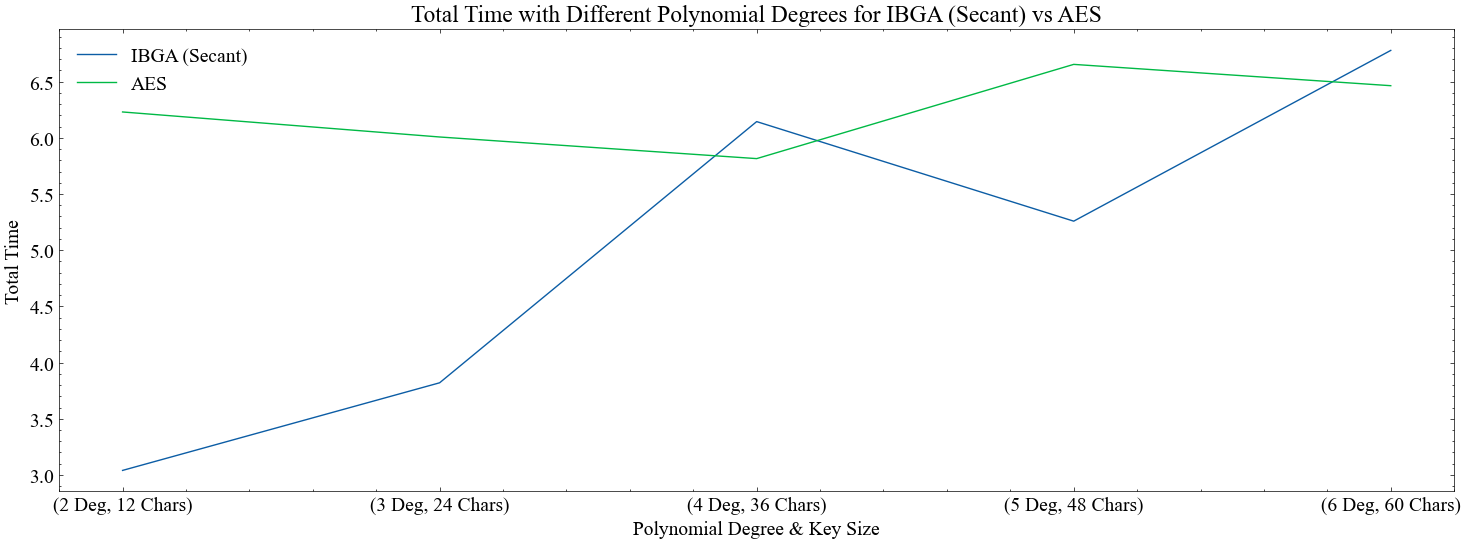

In [600]:
# Encryption Time Comparison
plt.figure(figsize=(18, 6))
plt.plot(polynomials_degrees, secant_different_deg_enc,  label='IBGA (Secant)')
plt.plot(polynomials_degrees, aes_different_keys_enc,  label='AES')
plt.xlabel('Polynomial Degree & Key Size')
plt.ylabel('Encryption Time')
plt.title(
    'Encryption Time with Different Polynomial Degrees for IBGA (Secant) vs AES')
plt.legend()
x_labels = [f"({deg} Deg, {key} Chars)" for deg,
            key in zip(degrees, key_sizes)]
plt.xticks(polynomials_degrees, x_labels)
plt.savefig(r"./encryption_time_comparison_deg.svg", format="svg")
plt.show()

# Decryption Time Comparison
plt.figure(figsize=(18, 6))
plt.plot(polynomials_degrees, secant_different_deg_dec,  label='IBGA (Secant)')
plt.plot(polynomials_degrees, aes_different_keys_dec,  label='AES')
plt.xlabel('Polynomial Degree & Key Size')
plt.ylabel('Decryption Time')
plt.title(
    'Decryption Time with Different Polynomial Degrees for IBGA (Secant) vs AES')
plt.legend()
x_labels = [f"({deg} Deg, {key} Chars)" for deg,
            key in zip(degrees, key_sizes)]
plt.xticks(polynomials_degrees, x_labels)
plt.savefig(r"./decryption_time_comparison_deg.svg", format="svg")
plt.show()

# Total Time Comparison
plt.figure(figsize=(18, 6))
plt.plot(polynomials_degrees, secant_different_deg_total,  label='IBGA (Secant)')
plt.plot(polynomials_degrees, aes_different_keys_total,  label='AES')
plt.xlabel('Polynomial Degree & Key Size')
plt.ylabel('Total Time')
plt.title('Total Time with Different Polynomial Degrees for IBGA (Secant) vs AES')
plt.legend()
x_labels = [f"({deg} Deg, {key} Chars)" for deg,
            key in zip(degrees, key_sizes)]
plt.xticks(polynomials_degrees, x_labels)
plt.savefig(r"./total_time_comparison_deg.svg", format="svg")
plt.show()